# Logistic Regression Walkthrough

The goal of this walkthrough is to demonstrate how to train a simple yet powerful machine learning model that is widely used in industry for a variety of applications - **Logistics Regression**. The model trained in the walkthrough has a potential for scaling to massive data sets by harnessing  the computational resources you may have (one or more CPU cores, one or more GPUs, a cluster of CPUs or a cluster of GPUs), transparently via the CNTK library.


## Logistic Regression
**Logistic Regression** is a fundamental machine learning technique that uses a linear weighted combination of features and generates probability-based predictions of different classes.  

There are two basic forms of LR: **Binary LR** (with a single output that can predict two classes) and **multinomial LR** (with multiple outputs, each of which is used to predict a single class). In this walkthrough we are going to focus on **BLR**.  

![LR-forms](http://www.cntk.ai/jup/logistic_neuron.jpg)

In **Binary Logistic Regression**, the input features are each scaled by an associated weight and summed together.  The sum is passed through a squashing (aka activation) function and generates an output in [0,1].  This output value (which can be thought of as a probability) is then compared with a threshold (such as 0.5) to produce a binary label (0 or 1).  This technique supports only classification problems with two output classes, hence the name binary LR.  In the binary LR example shown above, the `sigmoid` function is used as the squashing function.


$$\sigma(z) = \frac{1}{1 + e^{-z}} \text{,  where  } z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w}^T \cdot \textbf{x} + b $$



For **Logistics Regression** model training means estimating the model's parameters - **w** and **b** - so that the probabilities generated by the model are as close as possible to the observed labels. 

This is achieved by minimizing the *cost* or *loss* function, which "measures" the difference between predictions generated by the learnt model vs. the training data set.

`Cross-entropy` is a popular function to measure the loss. It is defined as:

$$ H(w) = -\frac{1}{N} \sum_{j=1}^N (y^{'}_j\log(y_j) + (1 - y^{'}_j)\log(1 - y_j))  $$  

where $y$ is our predicted probability from `sigmoid` function and $y'$ represents the ground-truth label. 

The trainer strives to reduce the `loss` function by different optimization approaches, Stochastic Gradient Descent (`sgd`) being one of the most popular one. Typically, one would start with random initialization of the model parameters. The `sgd` optimizer would calculate the `loss` or error between the predicted label against the corresponding ground-truth label and using `gradient-decent` generate a new set model parameters in a single iteration. 

The aforementioned model parameter update using a single observation at a time is attractive since it does not require the entire data set (all observation) to be loaded in memory and also requires gradient computation over fewer datapoints, thus allowing for training on large data sets. However, the updates generated using a single observation sample at a time can vary wildly between iterations.
An intermediate ground is to load a small set of observations and use an average of the `loss` or error from that set to update the model parameters. This subset is called a *minibatch*.
In the extreme case we can use all the observations in the training dataset.

With minibatches we often sample observation from the larger training dataset. We repeat the process of model parameters update using different combination of training samples and over a period of time minimize the `loss` (and the error). When the incremental error rates are no longer changing significantly or after a preset number of maximum minibatches to train, we claim that our model is trained.

One of the key parameter for optimization is called the `learning_rate`. For now, we can think of it as a scaling factor that modulates how much we change the parameters in any iteration. 



## Scenario overview

A cancer hospital has provided data and wants us to determine if a patient has  malignant cancer vs. a benign growth. This is known as a classification problem. To help classify each patient, we are given their age and the size of the tumor. Intuitively, one can imagine that younger patients and/or patient with small tumor size are less likely to have malignant cancer. The data set simulates this application where the each observation is a patient represented as a dot (in the plot below) where red color indicates malignant and blue indicates benign disease. Note: This is a toy example for learning, in real life there are large number of features from different tests/examination sources and doctors'  experience that play into the diagnosis/treatment decision for a patient.

## Initialize environment

In [1]:
from IPython.display import Image
import numpy as np
import cntk as C
import matplotlib.pyplot as plt
import sys
import os

# Select the right target device when this notebook is being tested:
if 'TEST_DEVICE' in os.environ:
    if os.environ['TEST_DEVICE'] == 'cpu':
        C.device.try_set_default_device(cntk.device.cpu())
    else:
        C.device.try_set_default_device(cntk.device.gpu(0))

/home/jarekk/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:280: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  'Matplotlib is building the font cache using fc-list. '


## Data Generation
We are using a simulated data set with two features and a binary label (benign:0 or malignant:1). 


In [4]:
dataset = np.loadtxt('../../Data/cancer.csv', delimiter=',', skiprows=1, dtype=np.float32)
print(dataset)

[[ 59.          56.           1.        ]
 [ 46.          54.70000076   1.        ]
 [ 58.          54.70000076   1.        ]
 ..., 
 [ 44.          23.29999924   0.        ]
 [ 40.          22.79999924   0.        ]
 [ 44.          20.89999962   0.        ]]


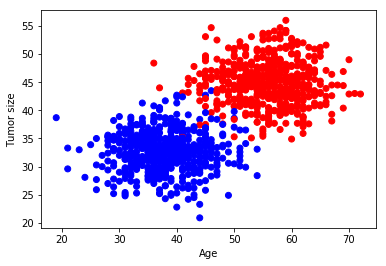

In [5]:
%matplotlib inline

colors = ['r' if l == 1. else 'b' for l in dataset[:,[2]]]
plt.scatter(dataset[:,[0]], dataset[:,[1]], c=colors)
plt.xlabel("Age")
plt.ylabel("Tumor size")
plt.show()

### Prepare training and validation features and labels
- Scale features to [0,1] range
- Reorganize into NumPy contiguous arrays to minimize costly conversions between NumPy and CTNK internal formats

In [8]:
np.random.seed(0)

def preprocess_dataset(dataset):
    training = np.copy(dataset)
    np.random.shuffle(training)
    training[:,[0,1]] /= np.max(training[:,[0,1]])
    index = int(len(training) * .7) 
    
    return np.ascontiguousarray(training[0:index, [0,1]]), \
           np.ascontiguousarray(training[0:index, [2]]), \
           np.ascontiguousarray(training[index+1:len(training), [0,1]]), \
           np.ascontiguousarray(training[index+1:len(training), [2]])

training_features, training_labels, validation_features, validation_labels = preprocess_dataset(dataset)

print(training_features[0:5])
print("")
print(training_labels[0:5])


[[ 0.43055555  0.34444442]
 [ 0.65277779  0.42638889]
 [ 0.91666669  0.60972226]
 [ 0.625       0.51250005]
 [ 0.47222221  0.47361109]]

[[ 0.]
 [ 0.]
 [ 1.]
 [ 0.]
 [ 0.]]


## Model Training

_Note that we have focused on making the code simple and straigthforward. It is not optimized for ultimate performance and may be numericaly unstable. In other labs we will follow best practices and guidelines for developing high performance and stable models._

### Set up a computational network


$$ \sigma(z) = \frac{1}{1 + e^{-z}} \text{,  where  } z = \sum_{i=1}^n w_i \times x_i + b = \textbf{w}^T \cdot \textbf{x} + b $$



In [9]:
input_dim = 2
output_dim = 1 

X = C.input(shape=(input_dim))
w = C.parameter(shape=(input_dim, output_dim))
b = C.parameter(shape=(output_dim))
y = C.sigmoid(X @ w + b)


### Define a loss function


$$ H(w) = -\frac{1}{N} \sum_{j=1}^N (y^{'}_j\log(y_j) + (1 - y^{'}_j)\log(1 - y_j))  $$  



In [10]:
y_ = C.input((output_dim))
loss = -C.reduce_sum(y_ * C.log(y) + (1 - y_) * C.log(1 - y), axis=C.Axis.all_axes())


### Configure the SGD trainer


In [11]:
from cntk.logging.progress_print import ProgressPrinter

progress_printer = ProgressPrinter(20)
learning_rate = 0.02
lr_schedule = C.learning_rate_schedule(learning_rate, C.UnitType.sample)
learner = C.sgd(y.parameters, lr_schedule)
trainer = C.Trainer(y, (loss), [learner], [progress_printer])

### Run the trainer



In [12]:
num_of_sweeps = 500 
for i in range(0, num_of_sweeps):
    trainer.train_minibatch({X : training_features, y_ : training_labels})


Learning rate per sample: 0.02
 Minibatch[   1-  20]: loss = 1477.887695 * 20, metric = 0.00% * 20;
 Minibatch[  21-  40]: loss = 939.773633 * 20, metric = 0.00% * 20;
 Minibatch[  41-  60]: loss = 109.699023 * 20, metric = 0.00% * 20;
 Minibatch[  61-  80]: loss = 69.311133 * 20, metric = 0.00% * 20;
 Minibatch[  81- 100]: loss = 66.303711 * 20, metric = 0.00% * 20;
 Minibatch[ 101- 120]: loss = 63.726953 * 20, metric = 0.00% * 20;
 Minibatch[ 121- 140]: loss = 61.491211 * 20, metric = 0.00% * 20;
 Minibatch[ 141- 160]: loss = 59.531055 * 20, metric = 0.00% * 20;
 Minibatch[ 161- 180]: loss = 57.796875 * 20, metric = 0.00% * 20;
 Minibatch[ 181- 200]: loss = 56.250195 * 20, metric = 0.00% * 20;
 Minibatch[ 201- 220]: loss = 54.861328 * 20, metric = 0.00% * 20;
 Minibatch[ 221- 240]: loss = 53.606445 * 20, metric = 0.00% * 20;
 Minibatch[ 241- 260]: loss = 52.466602 * 20, metric = 0.00% * 20;
 Minibatch[ 261- 280]: loss = 51.426563 * 20, metric = 0.00% * 20;
 Minibatch[ 281- 300]: loss

## Model evalulation

### Plot the learned decision boundry

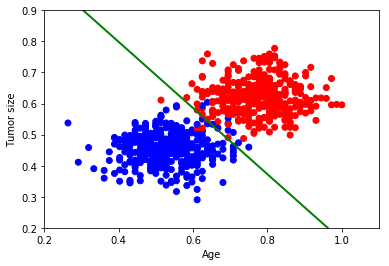

In [13]:
weights = y.parameters[0].value
bias = y.parameters[1].value
colors = ['r' if l == 1. else 'b' for l in training_labels]
plt.scatter(training_features[:,[0]], training_features[:,[1]], c=colors)
plt.plot([0, -bias[0]/weights[1][0]],
         [-bias[0]/weights[0][0], 0], c = 'g', lw =2)
plt.axis([0.2, 1.1, 0.2, 0.9])
plt.xlabel("Age")
plt.ylabel("Tumor size")
plt.show()

### Score the model on the validation dataset


In [14]:
result = y.eval({X: validation_features})
print(result[0:5])

[[ 0.99587232]
 [ 0.98158765]
 [ 0.00309822]
 [ 0.00432788]
 [ 0.00108764]]


### Calculate confusion matrix

In [15]:
from sklearn.metrics import confusion_matrix

predicted_labels = np.round(result)
print(confusion_matrix(validation_labels, predicted_labels))

[[146   1]
 [  4 148]]
